# Solucion de la ecuación de Poisson usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación

$$ \frac{d^2 u(x)}{d^2 x}  = f(x)\quad \forall x \in (0, \pi)$$

con $u(0) = u(\pi) = 0$.


## Aproximación de la función

En este caso tenemos una aproximación

$$u_\theta(x) \approx \operatorname{NN}(x; \theta)\, ,$$

dondee $\operatorname{NN}$ es una red neuronal con parámetros
entrenables $\theta$.

El residual para este problema estaría dado por

$$R(x) = \frac{d^2 u_\theta(x)}{d^2 x}  - f(x) \, .$$

Por el caracter no linealidad respecto a los parámetros
$\theta$ de las redes neuronales evaluar el residual
en una serie de puntos $x_i$  y forzarlo a ser cero
en estos puntos, llevaría a un sistema
no lineal de ecuaciones

$$R(x_i) = 0 \quad \forall x_i\, .$$

## Función de pérdida

Una alternativa a resolver el sistema de ecuaciones anteriormente
planteado es minimizar

$$\min_\theta \frac{1}{N}\sum_{i}^N |R(x_i)|^2 \, .$$

Que sería exactamente 0 si cada uno de los residuales es igual a 0.

A este problema le harían falta las condiciones de frontera. Para
esto se propone una función objetivo que las incluya

$$\min_\theta \frac{1}{N}\sum_{i}^N R(x_i)^2  + \lambda_1 u_\theta(0)^2
+ \lambda_2 u_\theta(\pi)^2\, .$$

## Ejemplo computacional

In [1]:
# Import required packages
using Lux                  # Neural network definition and training
using LuxCUDA
using TaylorDiff           # Automatic differentiation
using Optimization         # Optimization problem solving
using Optimisers           # Optimizers such as Adam
using Random               # Random number generation
using Plots                # Plotting utilities
using Zygote               # Automatic differentiation
using ComponentArrays      # Array utilities for handling model parameters
using Printf               # Advanced formatted printing
using LinearAlgebra        # Linear algebra operations
using Statistics           # Statistical operations
using OptimizationOptimisers  # Optimization extensions for Optimisers
using OptimizationOptimJL     # Optimization extensions for LBFGS

In [2]:
# Initial program setup
# Seeding for reproducibility
rng = Random.default_rng()
Random.seed!(rng, 0)

# Device configuration (CPU/GPU)
const DEVICE_CPU = cpu_device()  #  device cpu_device() gpu_device() 
const DEVICE_GPU = gpu_device()  #  device cpu_device() gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [9]:
# Data preparation
# Input range and target output
INPUT_RANGE = range(0, Float64.(pi), length=1000)
input_data = Float64.(reshape(collect(INPUT_RANGE), 1, :) |> DEVICE_GPU)   # Input data
f_rhs(x) = reshape(Float64.(-4*sin.(2*x)), 1, :)  # f_rhs
data = input_data    # Move data to the selected device 

1×1000 CuArray{Float64, 2, CUDA.DeviceMemory}:
 0.0  0.00314474  0.00628947  …  3.13216  3.1353  3.13845  3.14159

In [13]:
# Neural network definition
# Architecture: Network with multiple dense layers and tanh activation ; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros64
const HIDDEN_UNITS = 10
model = Chain(
    Dense(1 => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh;  init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => 1; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32)
)

# Model initialization
params, states = Lux.setup(rng, model)  # Initial parameters and states
params = Float64.(ComponentArray(params) |> DEVICE_GPU)  # Move parameters to the device
states = states |> DEVICE_GPU  # Move states to the device
smodel = StatefulLuxLayer{true}(model, params, states)  # Stateful model layer

StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(1 => 10, tanh),  # 20 parameters
        layer_2 = Dense(10 => 10, tanh),  # 110 parameters
        layer_3 = Dense(10 => 10, tanh),  # 110 parameters
        layer_4 = Dense(10 => 1),       # 11 parameters
    ),
)         # Total: 251 parameters,
          #        plus 0 states.

In [15]:
# Definir el valor de ε1
εmachine = eps(Float64)
ε2 = εmachine^(1/4)

function loss_adjoint(params, (input_data))
    # Predicción de la red neuronal
    f(input_data) = smodel(input_data, params)

    # Calcular la derivada numérica usando diferencias finitas centradas
    ddu(input_data)=Float64.((f(input_data .+ ε2) .- 2f0 .* f(input_data) .+ f(input_data .- ε2)) / (ε2^2))

    # Ressiduo de la ecuación diferencial
    res_eq = ddu(input_data) - f_rhs(input_data) 
    loss_eq = mean((res_eq).^2)  
    loss_bc = Array(((f([0] |> DEVICE_GPU) .- (0)).^2) + ((f([Float64.(pi)] |> DEVICE_GPU) .- (0)).^2))[1] 
    total_loss = loss_eq + loss_bc
    return total_loss
end

# Callback function
# Monitors training progress
function callback(state, l)
    state.iter % 100 == 1 && @printf "Iteration: %5d, Loss: %.12e\n" state.iter l
    return l < 1e-8  # Stop if loss is sufficiently small
end

callback (generic function with 1 method)

In [21]:
data = (input_data)  # Data tuple

# Definir el problema de optimización
opt_func = OptimizationFunction(loss_adjoint, Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, params, data)
iters = 5_01  # Número máximo de iteraciones

501

In [22]:
# Train using the Adam optimizer
res_adam = solve(opt_prob, Optimisers.Adam(1e-3), callback=callback, maxiters=iters)

Iteration:     1, Loss: 7.929718704071e+00
Iteration:   101, Loss: 4.078730290224e+00
Iteration:   201, Loss: 1.634620091156e+00
Iteration:   301, Loss: 9.371576710746e-01
Iteration:   401, Loss: 7.442647010992e-02
Iteration:   501, Loss: 2.881393982262e-03


retcode: Default
u: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:20, Axis(weight = ViewAxis(1:10, ShapedAxis((10, 1))), bias = 11:20)), layer_2 = ViewAxis(21:130, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_3 = ViewAxis(131:240, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_4 = ViewAxis(241:251, Axis(weight = ViewAxis(1:10, ShapedAxis((1, 10))), bias = 11:11)))}}}(layer_1 = (weight = [-0.3326689876262288; -0.25004296695533285; … ; 0.4987536833635247; -0.8129040104727644;;], bias = [0.2503163759257489, 0.3497002118257417, 0.30388764584188993, 0.36675259432296625, -0.17554442735749196, -0.360232590246284, -0.04356533918650206, 0.3746791059376839, 0.061581175224954356, -0.24721029012942267]), layer_2 = (weight = [0.18377402022539793 -0.8604554196066174 … -0.18208665095815063 0.30361885906888864; -0.6155818417743644 0.3555045998155739 … 0.4160566159105382 -0.5219622770609882

In [23]:
# Redefine the optimization problem with updated parameters
opt_prob = OptimizationProblem(opt_func, res_adam.u, data)

# Further training using the LBFGS optimizer
res_lbfgs = solve(opt_prob, OptimizationOptimJL.LBFGS(); callback, maxiters=iters)

Iteration:     1, Loss: 2.833650370248e-03
Iteration:   101, Loss: 5.791863553843e-05
Iteration:   201, Loss: 3.043803926993e-05
Iteration:   301, Loss: 7.769518249960e-06
Iteration:   401, Loss: 5.741759630446e-06
Iteration:   501, Loss: 4.552173132340e-06


retcode: Failure
u: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:20, Axis(weight = ViewAxis(1:10, ShapedAxis((10, 1))), bias = 11:20)), layer_2 = ViewAxis(21:130, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_3 = ViewAxis(131:240, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_4 = ViewAxis(241:251, Axis(weight = ViewAxis(1:10, ShapedAxis((1, 10))), bias = 11:11)))}}}(layer_1 = (weight = [-0.235006115898047; -0.22612040674642422; … ; 0.5095555496644022; -0.7320711101211564;;], bias = [0.16800654850350216, 0.35643750756041254, 0.2351170067482211, 0.3817478546685377, -0.2040271361546978, -0.41233928446869894, 0.06387169169492064, 0.3857406084485852, 0.10829146656351464, -0.3717461245668168]), layer_2 = (weight = [0.13051245625862323 -0.9183418615785209 … -0.15521445071088474 0.2868106789017514; -0.5599837024431059 0.4201646219932326 … 0.3901813507462598 -0.5121791519981981; … 

In [24]:
# Make predictions with the optimized model
pred = smodel(input_data, res_adam.u)

1×1000 CuArray{Float64, 2, CUDA.DeviceMemory}:
 0.00173446  0.0080359  0.0143342  0.0206293  …  -0.00824107  -0.00199329

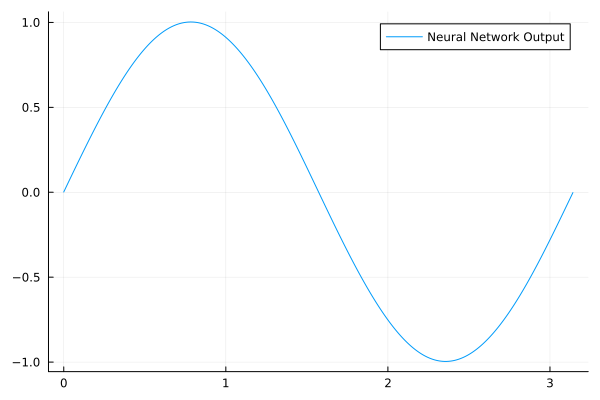

In [25]:
plot(Array(input_data)', Array(pred)', label="Neural Network Output")